In [118]:
#!pip install

C:\Users\jungm\anaconda3\envs\menv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)



Plotting Learning Curves
In the first column, first row the learning curve of a naive Bayes classifier
is shown for the digits dataset. Note that the training score and the
cross-validation score are both not very good at the end. However, the shape
of the curve can be found in more complex datasets very often: the training
score is very high at the beginning and decreases and the cross-validation
score is very low at the beginning and increases. In the second column, first
row we see the learning curve of an SVM with RBF kernel. We can see clearly
that the training score is still around the maximum and the validation score
could be increased with more training samples. The plots in the second row
show the times required by the models to train with various sizes of training
dataset. The plots in the third row show how much time was required to train
the models for each training sizes.



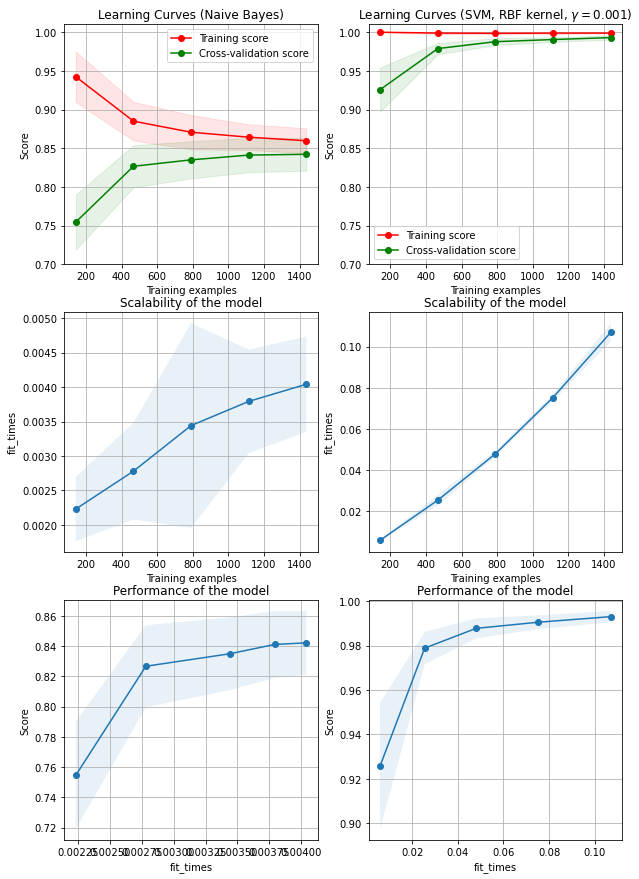

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import joblib

from plot.plot_learning_curve import plot_learning_curve

In [2]:
# HYPER PARAMETERS

class CFG:
    emb_dim = 200

args = CFG

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

# 1. Word Embedding

In [19]:
df_all = pd.concat([df_train, df_test])

In [20]:
# Basic text preprocessing

def split_process(x, q):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

In [21]:
# Get all combinations for training w2v (train + test)

food_combinations = []
for i in ['조식메뉴', '중식메뉴', '석식메뉴']:
    food_combinations += df_all[i].apply(lambda x: split_process(x, i)).to_list()

AttributeError: 'float' object has no attribute 'split'

In [22]:
# Train or load w2v model

TRAIN_W2V = True
try:
    model = Word2Vec.load('food_embedding.model')
    print("Model loaded")
except:
    if TRAIN_W2V:
        print("Training w2v")
        model = Word2Vec(sentences=food_combinations, vector_size=args.emb_dim, window=7, min_count=0, workers=4, sg=0, epochs=5000)
        model.save('food_embedding.model')
    else:
        print("Model loading failed. Do not train.")

Model loaded


In [126]:
# w2v demo
model.wv.most_similar('오징어국')

[('조랭이떡국', 0.6304399967193604),
 ('감자국', 0.6135469675064087),
 ('고추장찌개', 0.5833618640899658),
 ('김치두부국', 0.561978816986084),
 ('콩나물국', 0.5580398440361023),
 ('시래기국', 0.5491690635681152),
 ('민물새우찌개', 0.5454394817352295),
 ('열무된장국', 0.5452976226806641),
 ('무채국', 0.5440066456794739),
 ('재첩국', 0.5416214466094971)]

# 2. Preprocess

In [4]:
def process_date(df):
    df['일자'] = pd.to_datetime(df['일자'], format="%Y-%m-%d")
    df['year'] = df['일자'].dt.year
    df['month'] = df['일자'].dt.month
    df['day'] = df['일자'].dt.day
    df = df.drop('일자', axis=1)
    return df

def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    vec_ = np.zeros(args.emb_dim)
    for i in x_:
        vec = model.wv.get_vector(i)
        vec_ += vec
    vec_ /= len(x_)
    return vec_

In [5]:
# General preprocessing
df_train = process_date(df_train)
day_encoder = LabelEncoder()
df_train['요일'] = day_encoder.fit_transform(df_train['요일'])

In [6]:
# Get embedding
df_train['조식메뉴_embedding'] = df_train['조식메뉴'].apply(lambda x: get_food_embedding(x))
df_train['중식메뉴_embedding'] = df_train['중식메뉴'].apply(lambda x: get_food_embedding(x))
df_train['석식메뉴_embedding'] = df_train['석식메뉴'].apply(lambda x: get_food_embedding(x))

NameError: name 'model' is not defined

In [ ]:
df_menu = df_train.iloc[:,6:9]

In [7]:
y_lunch = df_train['중식계']
y_dinner = df_train['석식계']
df_train.drop(['조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계'], axis=1, inplace=True)

In [8]:
X_common = df_train.iloc[:, :9]
X_common # embedding 제외한 수치데이터

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,year,month,day
0,3,2601,50,150,238,0.0,2016,2,1
1,4,2601,50,173,319,0.0,2016,2,2
2,2,2601,56,180,111,0.0,2016,2,3
3,1,2601,104,220,355,0.0,2016,2,4
4,0,2601,278,181,34,0.0,2016,2,5
...,...,...,...,...,...,...,...,...,...
1200,2,2983,75,198,4,391.0,2021,1,20
1201,1,2983,92,231,462,351.0,2021,1,21
1202,0,2983,255,248,1,303.0,2021,1,22
1203,3,2983,107,153,616,327.0,2021,1,25


In [12]:
# "간단하게 80점 밑으로" 코드 참고
X_common['식사가능자수'] = X_common['본사정원수'] - X_common['본사휴가자수'] - X_common['현본사소속재택근무자수']
X_common_dn = X_common.drop(['본사정원수', '본사휴가자수', '현본사소속재택근무자수'], axis=1)
X_common.drop(['본사정원수', '본사휴가자수', '현본사소속재택근무자수', 'year'], axis=1, inplace=True)
X_common.head()

KeyError: '본사정원수'

In [11]:
X_common_dn.head(2)

,요일,본사출장자수,본사시간외근무명령서승인건수,year,month,day,식사가능자수
0,3,150,238,2016,2,1,2551.0
1,4,173,319,2016,2,2,2551.0


In [104]:
# emb_arr_lunch = np.array(df_train.iloc[:, 9].to_numpy().tolist()) + np.array(df_train.iloc[:, 10].to_numpy().tolist()) # Ver 1
# emb_arr_dinner = np.array(df_train.iloc[:, 9].to_numpy().tolist()) + np.array(df_train.iloc[:, 11].to_numpy().tolist()) # Ver 1
emb_arr_lunch = np.array(df_train.iloc[:, 10].to_numpy().tolist()) # Ver 2
emb_arr_dinner = np.array(df_train.iloc[:, 11].to_numpy().tolist()) # Ver 2

X_lunch = np.concatenate((X_common.to_numpy(), emb_arr_lunch), axis=1)
X_dinner = np.concatenate((X_common.to_numpy(), emb_arr_dinner), axis=1)

In [13]:
# Train / Test split

# num_only = True: feature로 수치 데이터만 사용 / False: W2V 벡터 사용
num_only = True

if num_only:
    X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch = train_test_split(X_common.to_numpy(), y_lunch, test_size=0.1, random_state=42)
    X_train_dinner, X_test_dinner, y_train_dinner, y_test_dinner = train_test_split(X_common_dn.to_numpy(), y_dinner, test_size=0.1, random_state=42)
else:
    X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch = train_test_split(X_lunch, y_lunch, test_size=0.1, random_state=42)
    X_train_dinner, X_test_dinner, y_train_dinner, y_test_dinner = train_test_split(X_dinner, y_dinner, test_size=0.1, random_state=42)

In [15]:
print(X_train_lunch.shape)
print(X_train_dinner.shape)

(1084, 6)
(1084, 7)


### Dataset 변수 목록
※ f : 학습에 사용되는 feature 수  
__X_common__ : W2V제외한 수치데이터 (점식, 저녁 동일) __(DataFrame)__    
__emb_arr_lunch/dinner__ : 학습된 W2V 데이터 (점심/저녁)   

__X_lunch__ : 점심식사 데이터 (1205, f)   
__y_lunch__ : 점심식사 레이블 중식계 (1205,)   
__X_dinner__ : 저녁식사 데이터 (1205, f)   
__y_dinner__ : 저녁식사 레이블 석식계 (1205,)   

__X_train_lunch__ : 점심식사 훈련 데이터 (1084, f)   
__y_train_lunch__ : 점식식사 훈련 레이블 (1084, f)    

__X_test_lunch__ : 점심식사 시험 데이터 (121, f)   
__y_test_lunch__ : 점식식사 시험 레이블 (121, f)   

# 3. Modeling
사용하지 않는 모델 부분은 한꺼번에 실행 했을 때 실행 안되게 Markdown셀로 바꿔놨음.  
셀 선택하고 y 누르면 코드 셀로 바뀜

# 1. Simple LGBM Regressor w/o tuning
model_lunch = LGBMRegressor()
model_lunch.fit(X_train_lunch, y_train_lunch)

model_dinner = LGBMRegressor()
model_dinner.fit(X_train_dinner, y_train_dinner)

# Validate
pred_lunch = model_lunch.predict(X_test_lunch)
pred_dinner = model_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("lunch rmse: ", np.sqrt(mean_squared_error(y_test_lunch, pred_lunch)))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))
print("dinner rmse: ", np.sqrt(mean_squared_error(y_test_dinner, pred_dinner)))

# 1-1. LGBM GridSearchCV
TRAIN_LGBM = True

model_name_lunch = 'lgbm_lunch3_v4.joblib'
model_name_dinner = 'lgbm_dinner3_v4.joblib'

try:
    estimator_lunch = joblib.load('models/'+model_name_lunch)
    estimator_dinner = joblib.load('models/'+model_name_dinner)
    print('Model loaded')
except:
    if TRAIN_LGBM == True:
        print('Models not found. Creating models')
        model_lunch = LGBMRegressor()
        model_dinner = LGBMRegressor()

        params = {'boosting': ['gbdt', 'rf', 'dart', 'goss'],
                  'learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08]}
        grid_lgbm_lunch = GridSearchCV(model_lunch, param_grid=params, cv=3, refit=True)
        grid_lgbm_dinner = GridSearchCV(model_dinner, param_grid=params, cv=3, refit=True)

        grid_lgbm_lunch.fit(X_train_lunch, y_train_lunch)
        grid_lgbm_dinner.fit(X_train_dinner, y_train_dinner)

        print('LUNCH - GridSearchCV 최적 파라미터:', grid_lgbm_lunch.best_params_)
        print('LUNCH - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lgbm_lunch.best_score_))

        print('DINNER - GridSearchCV 최적 파라미터:', grid_lgbm_dinner.best_params_)
        print('DINNER - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lgbm_dinner.best_score_))

        # 1-2. LGBM Regressor with tuning

        estimator_lunch = grid_lgbm_lunch.best_estimator_
        #model_lunch = LGBMRegressor()
        #estimator_lunch.fit(X_train_lunch, y_train_lunch)

        estimator_dinner = grid_lgbm_dinner.best_estimator_
        #model_dinner = LGBMRegressor()
        #model_dinner.fit(X_train_dinner, y_train_dinner)

        joblib.dump(estimator_lunch, 'models/'+model_name_lunch)
        joblib.dump(estimator_dinner, 'models/'+model_name_dinner)
    else:
        print('Model loading failed. Do not train')

# Validate
pred_lunch = estimator_lunch.predict(X_test_lunch)
pred_dinner = estimator_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("lunch rmse: ", np.sqrt(mean_squared_error(y_test_lunch, pred_lunch)))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))
print("dinner rmse: ", np.sqrt(mean_squared_error(y_test_dinner, pred_dinner)))

# Learning curve
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)
plot_learning_curve(estimator_lunch, 'Learning curve - LGBM Lunch', X_train_lunch, y_train_lunch, cv=cv)
plot_learning_curve(estimator_dinner, 'Learning curve - LGBM Dinner', X_train_dinner, y_train_dinner, cv=cv)

# 2. Simple XGBRegressor w/o tuning
model_lunch = XGBRegressor()
model_lunch.fit(X_train_lunch, y_train_lunch)

model_dinner = XGBRegressor()
model_dinner.fit(X_train_dinner, y_train_dinner)

# Validate
pred_lunch = model_lunch.predict(X_test_lunch)
pred_dinner = model_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("lunch rmse: ", np.sqrt(mean_squared_error(y_test_lunch, pred_lunch)))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))
print("dinner rmse: ", np.sqrt(mean_squared_error(y_test_dinner, pred_dinner)))

In [16]:
# 2-1. XGB GridSearchCV

TRAIN_XGB = True

model_name_lunch = 'xgb_lunch_f.joblib'
model_name_dinner = 'xgb_dinner_f.joblib'

try:
    estimator_lunch = joblib.load('models/'+model_name_lunch)
    estimator_dinner = joblib.load('models/'+model_name_dinner)
    print('Model loaded')
except:
    if TRAIN_XGB:
        print('Models not found. Creating models')
        model_lunch = XGBRegressor(gpu_id=0)
        model_dinner = XGBRegressor(gpu_id=0)

        params = {'learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
                  'booster': ['gbtree', 'gblinear', 'dart']}
        grid_xgb_lunch = GridSearchCV(model_lunch, param_grid=params, cv=3, refit=True, scoring='neg_mean_absolute_error')
        grid_xgb_dinner = GridSearchCV(model_dinner, param_grid=params, cv=3, refit=True, scoring='neg_mean_absolute_error')

        grid_xgb_lunch.fit(X_train_lunch, y_train_lunch)
        grid_xgb_dinner.fit(X_train_dinner, y_train_dinner)

        print('LUNCH - GridSearchCV 최적 파라미터:', grid_xgb_lunch.best_params_)
        print('LUNCH - GridSearchCV 최고 neg_mae: {0:.4f}'.format(grid_xgb_lunch.best_score_))

        print('DINNER - GridSearchCV 최적 파라미터:', grid_xgb_dinner.best_params_)
        print('DINNER - GridSearchCV 최고 neg_mae: {0:.4f}'.format(grid_xgb_dinner.best_score_))

        estimator_lunch = grid_xgb_lunch.best_estimator_
        estimator_dinner = grid_xgb_dinner.best_estimator_

        joblib.dump(estimator_lunch, 'models/'+model_name_lunch)
        joblib.dump(estimator_dinner, 'models/'+model_name_dinner)
    else:
        print('Model loading failed.')

Models not found. Creating models
LUNCH - GridSearchCV 최적 파라미터: {'booster': 'dart', 'learning_rate': 0.09}
LUNCH - GridSearchCV 최고 neg_mae: -78.7670
DINNER - GridSearchCV 최적 파라미터: {'booster': 'dart', 'learning_rate': 0.089}
DINNER - GridSearchCV 최고 neg_mae: -57.8116


In [17]:
# Validate
pred_lunch = estimator_lunch.predict(X_test_lunch)
pred_dinner = estimator_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("lunch rmse: ", np.sqrt(mean_squared_error(y_test_lunch, pred_lunch)))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))
print("dinner rmse: ", np.sqrt(mean_squared_error(y_test_dinner, pred_dinner)))

lunch mae:  75.94238230807723
lunch rmse:  102.15874886656644
dinner mae:  52.03657405632587
dinner rmse:  75.96118276246445


# 3-0. Impute nans for emb_dinner (mean)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_train_dinner)
X_train_dinner_imp = imputer.transform(X_train_dinner)


# 3. Simple RF w/o tuning
model_lunch = RandomForestRegressor(criterion='mae')
model_lunch.fit(X_train_lunch, y_train_lunch)

model_dinner = RandomForestRegressor(criterion='mae')
model_dinner.fit(X_train_dinner_imp, y_train_dinner)

# Validate
pred_lunch = model_lunch.predict(X_test_lunch)
pred_dinner = model_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("lunch rmse: ", np.sqrt(mean_squared_error(y_test_lunch, pred_lunch)))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))
print("dinner rmse: ", np.sqrt(mean_squared_error(y_test_dinner, pred_dinner)))

# 3-1. RF GridSearchCV

model_lunch = RandomForestRegressor(criterion = 'mae')
model_dinner = RandomForestRegressor(criterion = 'mae')

params = {'max_depth':[None,3,5],
          'min_samples_leaf': [2, 3, 5],
          'n_estimators': [100, 200, 500]}
grid_rf_lunch = GridSearchCV(model_lunch, param_grid=params, cv=2, refit=True)
grid_rf_dinner = GridSearchCV(model_dinner, param_grid=params, cv=2, refit=True)

grid_rf_lunch.fit(X_train_lunch, y_train_lunch)
grid_rf_dinner.fit(X_train_dinner, y_train_dinner)

print('LUNCH - GridSearchCV 최적 파라미터:', grid_rf_lunch.best_params_)
print('LUNCH - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rf_lunch.best_score_))

print('DINNER - GridSearchCV 최적 파라미터:', grid_rf_dinner.best_params_)
print('DINNER - GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rf_dinner.best_score_))

# 3-2. RF Regressor with tuning

estimator_lunch = grid_rf_lunch.best_estimator_
estimator_dinner = grid_rf_dinner.best_estimator_

# Validate
pred_lunch = estimator_lunch.predict(X_test_lunch)
pred_dinner = estimator_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("lunch rmse: ", np.sqrt(mean_squared_error(y_test_lunch, pred_lunch)))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))
print("dinner rmse: ", np.sqrt(mean_squared_error(y_test_dinner, pred_dinner)))

# 4. Simple NN
#모델 생성
from keras.models import Sequential, load_model, clone_model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, ReLU
from keras.layers.experimental.preprocessing import Rescaling
from keras.applications import ResNet50


loss = 'mae'
optimizer = 'adam'
metrics = ['mae', 'mse']

model_name_lunch = 'lunch_model2.h5'
model_name_dinner = 'dinner_model2.h5'
try:
    model_lunch = load_model('models/'+model_name_lunch)
    model_dinner = load_model('models/'+model_name_dinner)
    print('Models loaded')
except:
    print('Models not found. Creating models')
    model_lunch = Sequential()
    model_lunch.add(Dense(32, input_shape=(X_train_lunch.shape[1],), activation='relu', kernel_initializer='he_normal'))
    model_lunch.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
    model_lunch.add(Dense(1))

    model_lunch.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metrics)

    
    model_dinner = clone_model(model_lunch)
    model_dinner.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metrics)


model_lunch.summary()
model_dinner.summary()


num_epochs = 100
batch_size = 1

history_lunch = model_lunch.fit(X_train_lunch, y_train_lunch, verbose=2, epochs=num_epochs, batch_size=batch_size,
                               validation_split=0.1)

history_dinner = model_dinner.fit(X_train_dinner, y_train_dinner, verbose=2, epochs=num_epochs, batch_size=batch_size,
                                 validation_split=0.1)

pred_lunch = model_lunch.predict(X_test_lunch)
pred_dinner = model_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("lunch rmse: ", np.sqrt(mean_squared_error(y_test_lunch, pred_lunch)))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))
print("dinner rmse: ", np.sqrt(mean_squared_error(y_test_dinner, pred_dinner)))


plt.plot(history_lunch.history['mae'])
plt.plot(history_lunch.history['val_mae'])
plt.title('MAE - Lunch')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_dinner.history['mae'])
plt.plot(history_dinner.history['val_mae'])
plt.title('MAE - Dinner')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model_lunch.save('models/'+model_name_lunch)
model_dinner.save('models/'+model_name_dinner)

## 모델 별 성능 기록
### XGBRegressor
lunch mae:  86.69192933642175  
lunch rmse:  112.93651738982074  
dinner mae:  54.666629522299964  
dinner rmse:  77.96158646531192  

### LGBMRegressor
lunch mae:  86.56267186010179  
lunch rmse:  110.08922511823108  
dinner mae:  51.21847190543675  
dinner rmse:  74.4542713687093  


### RandomForestRegressor
lunch mae:  87.01206611570248  
lunch rmse:  111.36138052631743  
dinner mae:  53.06252066115703  
dinner rmse:  79.16125760744164  

### LGBMRegressor (with Tuning)
___Lunch에서 가장 좋은 mae 보임_  
_Dinner에서도 심플 LGBM과 비슷함(살짝 안좋음)___  
lunch mae:  81.5327547899601  
lunch rmse:  103.0398502595158  
dinner mae:  51.65815648984224  
dinner rmse:  76.77894930280426  

### XGBRegressor (with Tuning)
___Dinner에서 가장 좋은 mae___   
lunch mae:  84.07230648324509  
lunch rmse:  106.18806243199757  
dinner mae:  50.17658501026059  
dinner rmse:  74.31690168181626  

### model1
lunch mae:  96.23241128212165  
lunch rmse:  119.30347128907381  
dinner mae:  97.5268769067181  
dinner rmse:  140.37102251104142  

# Inference

### test dataset 변수 목록
__X_test_common__ : 테스트용 수치데이터  
__test_emb_arr_lunch/dinner__ : 테스트용 W2V 데이터  

__test_lunch__ : 테스트용 점심식사 데이터(수치+W2V)  
__test_dinner__ : 테스트용 저녁식사 데이터(수치+W2V)  

In [25]:
df_test = pd.read_csv('./test.csv')

In [26]:
# Apply general preprocessing to test dataset
df_test= process_date(df_test)
df_test['요일'] = day_encoder.transform(df_test['요일'])
df_test['조식메뉴_embedding'] = df_test['조식메뉴'].apply(lambda x: get_food_embedding(x))
df_test['중식메뉴_embedding'] = df_test['중식메뉴'].apply(lambda x: get_food_embedding(x))
df_test['석식메뉴_embedding'] = df_test['석식메뉴'].apply(lambda x: get_food_embedding(x))
df_test.drop(['조식메뉴', '중식메뉴', '석식메뉴'], axis=1, inplace=True)
X_test_common = df_test.iloc[:, :9]
X_test_common.head(3)

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,year,month,day
0,2,2983,88,182,5,358.0,2021,1,27
1,1,2983,104,212,409,348.0,2021,1,28
2,0,2983,270,249,0,294.0,2021,1,29


In [27]:
X_test_common['식사가능자수'] = X_test_common['본사정원수'] - X_test_common['본사휴가자수'] - X_test_common['현본사소속재택근무자수']
X_test_common_dn = X_test_common.drop(['본사정원수', '본사휴가자수', '현본사소속재택근무자수'], axis=1)
X_test_common.drop(['본사정원수', '본사휴가자수', '현본사소속재택근무자수', 'year'], axis=1, inplace=True)
X_test_common.head()

,요일,본사출장자수,본사시간외근무명령서승인건수,month,day,식사가능자수
0,2,182,5,1,27,2537.0
1,1,212,409,1,28,2531.0
2,0,249,0,1,29,2419.0
3,3,154,538,2,1,2494.0
4,4,186,455,2,2,2548.0


In [28]:
X_test_common_dn.head(2)

,요일,본사출장자수,본사시간외근무명령서승인건수,year,month,day,식사가능자수
0,2,182,5,2021,1,27,2537.0
1,1,212,409,2021,1,28,2531.0


In [29]:
# Get embedding
test_emb_arr_lunch = np.array(df_test.iloc[:, 10].to_numpy().tolist()) # Ver 2
test_emb_arr_dinner = np.array(df_test.iloc[:, 11].to_numpy().tolist()) # Ver 2
# Concat

num_only_test = True

if num_only_test:
    test_lunch = X_test_common.to_numpy()
    test_dinner = X_test_common_dn.to_numpy()
else:
    test_lunch = np.concatenate((X_test_common.to_numpy(), test_emb_arr_lunch), axis=1)
    test_dinner = np.concatenate((X_test_common.to_numpy(), test_emb_arr_dinner), axis=1)

In [30]:
# Inference
try:
    model_lunch = estimator_lunch
    model_dinner = estimator_dinner
    print('Estimator prediction')
except:
    print('Model prediction')
test_pred_lunch = model_lunch.predict(test_lunch)
test_pred_dinner = model_dinner.predict(test_dinner)

submission_df = pd.read_csv('./sample_submission.csv')
submission_df['중식계'] = test_pred_lunch
submission_df['석식계'] = test_pred_dinner

Estimator prediction


In [31]:
# Save
sub_fname = 'sub_xgb_f.csv'

submission_df.to_csv(sub_fname, index=False)

In [32]:
tmp_df = pd.read_csv(sub_fname)
tmp_df

,일자,중식계,석식계
0,2021-01-27,1055.63440,170.30447
1,2021-01-28,994.01350,360.45712
2,2021-01-29,567.06946,233.90048
3,2021-02-01,1163.25050,459.64160
4,2021-02-02,996.86430,435.63574
5,2021-02-03,1037.27730,415.14453
6,2021-02-04,1074.15900,441.86070
7,2021-02-05,706.01355,312.02957
8,2021-02-08,1263.06800,582.39294
9,2021-02-09,1078.22830,529.08090
